# Color Space Conversion

This example showcases different color space conversion operations available in DALI.

## Defining the pipeline

In [4]:
import nvidia.dali.ops as ops
import nvidia.dali.types as types
from nvidia.dali.pipeline import Pipeline

image_dir = "images"

class SimplePipeline(Pipeline):
    def __init__(self, batch_size, num_threads, device_id):
        super(SimplePipeline, self).__init__(batch_size, num_threads, device_id, seed = 12)
        self.input = ops.FileReader(file_root = image_dir)
        self.decode = ops.HostDecoder(output_type = types.RGB)
        self.copy = ops.Copy(device = 'gpu')
        
        def add_color_space_conversion(conversions, name, input_type, output_type):
            conversions['cpu'][name] = ops.ColorSpaceConversion(device = 'cpu', image_type = input_type, output_type = output_type)
            conversions['gpu'][name] = ops.ColorSpaceConversion(device = 'gpu', image_type = input_type, output_type = output_type)
        
        self.conversions = { 'cpu': {}, 'gpu': {} }
        add_color_space_conversion(self.conversions, 'rgb2bgr', types.RGB, types.BGR )
        add_color_space_conversion(self.conversions, 'rgb2ycbcr', types.RGB, types.YCbCr )
        add_color_space_conversion(self.conversions, 'rgb2gray', types.RGB, types.GRAY )
        
    def define_graph(self):
        self.jpegs, self.labels = self.input()
        images = self.decode(self.jpegs)
        images_gpu = images.gpu()
        outputs = [images] 
        for device in ['cpu', 'gpu']:
            conv_list = list(self.conversions[device].values())
            n = len(conv_list)
            out = [images_gpu if device == 'gpu' else images for _ in range(n)]
            for i in range(n):
                out[i] = conv_list[i](out[i])
            outputs = outputs + out         
        return outputs

    def iter_setup(self):
        pass

## Building and running the pipeline

In [5]:
batch_size = 32

pipe = SimplePipeline(batch_size=batch_size, num_threads=2, device_id = 0)
pipe.build()
pipe_out = pipe.run()

## Visualizing the results

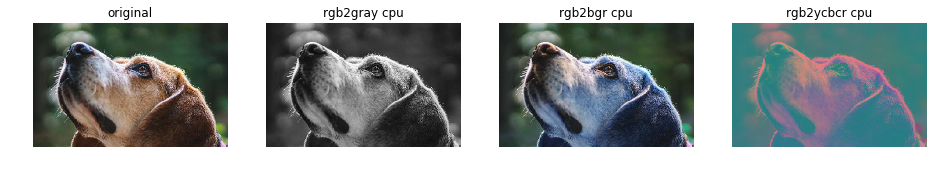

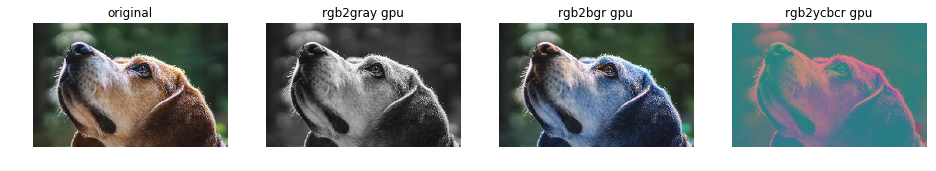

In [6]:
import matplotlib.pyplot as plt
import math
from synsets import imagenet_synsets
import matplotlib.gridspec as gridspec
n = 1
len_outputs = len(pipe_out)
original_images = pipe_out[0]
n_conversions = (len_outputs - 1) / 2

conversions_cpu = [elem for elem in pipe_out[1:n_conversions+1]]
conversions_gpu = [elem for elem in pipe_out[n_conversions+1:]]

titles = list(pipe.conversions['cpu']) # gpu is the same 

def show_images(original, conversions, titles_conversions, device):
    outputs = conversions
    titles  = [elem + " " + device for elem in titles_conversions]
    len_outputs = len(outputs)
    fig = plt.figure(figsize = (16,16))
    columns = 4
    rows = 1 + int(math.ceil(1.*len_outputs / columns))
    gs = gridspec.GridSpec(rows, columns)
      
    plt.subplot(gs[0])
    plt.axis("off")
    plt.title("original")
    plt.imshow(original.at(n))
    
    for i in range(len_outputs):
        plt.subplot(gs[i+1])
        plt.axis("off")
        plt.title(titles[i])
        img_chw = outputs[i].asCPU().at(n) if device == 'gpu' else outputs[i].at(n)
        shape = img_chw.shape
        if shape[2] == 1:
            plt.imshow(img_chw.reshape(shape[0], shape[1]), cmap='gray')
        else:
            plt.imshow(img_chw)

show_images(original=original_images, conversions=conversions_cpu, titles_conversions=titles, device='cpu')
show_images(original=original_images, conversions=conversions_gpu, titles_conversions=titles, device='gpu')